<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Some-Configuration" data-toc-modified-id="Some-Configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Some Configuration</a></span></li><li><span><a href="#Create-pedestrian-source/target-mapping" data-toc-modified-id="Create-pedestrian-source/target-mapping-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create pedestrian source/target mapping</a></span></li><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data loading</a></span></li><li><span><a href="#Some-plotting" data-toc-modified-id="Some-plotting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Some plotting</a></span></li><li><span><a href="#Create-od-matrices" data-toc-modified-id="Create-od-matrices-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create od-matrices</a></span><ul class="toc-item"><li><span><a href="#Load-uniqe-timesteps-and-convert-them-to-datetimes" data-toc-modified-id="Load-uniqe-timesteps-and-convert-them-to-datetimes-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Load uniqe timesteps and convert them to datetimes</a></span></li></ul></li></ul></div>

In [1]:
import matplotlib.pyplot as mpl
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch
import random
from collections import OrderedDict
from datetime import datetime

from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
np.set_printoptions(suppress=True)

In [19]:
def random_color():
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())


def to_point(pedestrian):
    return Point(pedestrian[2] / 1000, pedestrian[3] / -1000)


def to_path(points):
    return 


class Pedestrian:
    def __init__(self, frame):
        self.frame = frame
        
        self.frame[['x','y']] = self.frame[['x','y']] / 1000
        self.frame['y'] *=  -1
        
        self.id = self.frame.pedestrianId[0]
        self.start = Point(self.frame.x.values[0], self.frame.y.values[0])
        
        if len(self.frame.x.values) > 1:
            self.end = Point(self.frame.x.values[-1], self.frame.y.values[-1])
        else:
            self.end = self.start
        
        self.path = None
        

    def has_path(self):
        return self.path is not None or len(self.frame.timestep) > 1
    
    def get_pedestrianId(self):
        return self.id
            
    def get_start(self):
        return self.start
    
    def get_end(self):
        return self.end
    
    def get_path(self):
        if self.path is None and self.has_path():
            self.path = LineString(list(zip(self.frame.x.values, self.frame.y.values)))
            
        return self.path

def plot_source(sourceId, mapping, path, sources, skip=1, mode='all'):
    pedestrians = mapping[mapping['source'] == sourceId].pedestrianId.values
    plot_trajectories(pedestrians, path, sources, skip=skip, mode=mode)
    
    
def plot_trajectories(pedestrians, path, sources, skip=1, mode='traj', showsources=True, color='k', save=False, show_image=True,linewidth=0.1):
    minx = -46;
    maxx = 10;
    miny = -7;
    maxy = 8;
    
    pedestrians = pedestrians[::skip]
    
    fig, ax = mpl.subplots(ncols=1, nrows=1, figsize=(11, 6), dpi=96)
    
    for ped in tqdm(pedestrians, total=len(pedestrians)):
        pedestrian = Pedestrian(pd.read_csv(os.path.join(path, ped+'.csv'), names=['timestep', 'pedestrianId', 'x', 'y']))
        
        
        if not(pedestrian.get_path() is None):
            x, y = pedestrian.get_path().xy
            
            if 'start' in mode:
                ax.plot(x[0], y[0], 'c.', markersize=5, label='start')

            if 'end' in mode:
                ax.plot(x[-1], y[-1], 'y.', markersize=5, label='end')
            
            if mode == 'traj':
                ax.plot(x, y, color, linewidth=linewidth)
        else:
            print("ped: ",os.path.join(path, ped+'.csv')," does not have a path! ")
            print(pedestrian.has_path(), pedestrian.get_start(), pedestrian.get_end())
        
    if show_image:
        img = mpl.imread("../Layout2.png")
        ax.imshow(img, extent=[minx, maxx, miny - 3, maxy + 4])
    
    if showsources:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'limegreen', 'deepskyblue', 'blueviolet']
        for index, s in enumerate(sources):
            ax.add_patch(PolygonPatch(s, linewidth=2, edgecolor=colors[index % len(colors)], facecolor='none', label=str(index)))
    
    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    
    ax.legend(by_label.values(), by_label.keys(), loc='lower left', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=len(sources) + 2)
    
    ax.grid()
    
    if save:
        fig.savefig(os.path.join(path, 'plot.pdf'))
    

# Some Configuration

In [3]:
# base directory to use
day = "20190905"
base = '/media/veracrypt1/objectstream_{0}/'.format(day)

# sources/targets identified
sources = [
    Polygon([[-44, -6], [-46, -6], [-46, 8], [-44, 8]]), # 0 -> 1
    Polygon([[-42, 7], [-36, 7], [-36, 9], [-42, 9]]), # 4 -> 2
    Polygon([[-23.5, 6.5], [-20, 6.5], [-20, 8.5], [-23.5, 8.5]]), # 7 -> 3
    Polygon([[-0.5, 4.5], [2, 4.5], [2, 8], [-0.5, 8]]), # 1 -> 4
    Polygon([[4, 5], [6, 5], [6, 1], [4, 1]]), # 2 -> 5
    Polygon([[-0.5, -1.5], [2.5, -1.5], [2.5, 1.5], [-0.5, 1.5]]), # 3 -> 6
    Polygon([[-5, -3.5], [-2.5, -3.5], [-2.5, -5.5], [-5, -5.5]]), # 8 -> 7
    Polygon([[-25, -5], [-19.5, -5], [-19.5, -9], [-25, -9]]), # 6 -> 8
    Polygon([[-42, -6], [-37, -6], [-37, -8], [-42, -8]]) # 5 -> 9
]

# Create pedestrian source/target mapping
<span style="color:red; font-weight:bold; font-size: 20px">This should only be done once!!</span>

pedestrians = list(filter(lambda x: 'plot' not in x, os.listdir(os.path.join(base, 'pedestrians'))))
removed_mappings = pd.read_csv('removed_mappings.csv')
removed_mappings = removed_mappings.values.tolist()

pedestrian2source = []
# some origin to destination distributions have to be removed as the pedestrian count is too small or zero
# create second mapping where these are mapped to -1,-1 instead
pedestrian2source_reduced = []

for ped in tqdm(pedestrians, total=len(pedestrians)):
    pedestrian = Pedestrian(pd.read_csv(os.path.join(base, 'pedestrians', ped), names=['timestep', 'pedestrianId', 'x', 'y']))
    
    ped = []
    
    start = pedestrian.get_start()
    end = pedestrian.get_end()
    
    source = -1
    target = -1
    
    for index, area in enumerate(sources):
        if source == -1 and area.contains(start):
            source = index
            
        if target == -1 and area.contains(end):
            target = index

    pedestrian2source.append([pedestrian.get_pedestrianId(), source, target])
    
    combination = [source, target]
    if combination in removed_mappings:
        source = -1
        target = -1

    pedestrian2source_reduced.append([pedestrian.get_pedestrianId(), source, target])

# save mapping
df = pd.DataFrame(pedestrian2source, columns=['pedestrianId', 'source', 'target'])
df = df.astype({'source': np.int8, 'target': np.int8})
df.to_csv(os.path.join(base, 'mapping{0}.csv'.format(datetime.now())), index=False)

df = pd.DataFrame(pedestrian2source_reduced, columns=['pedestrianId', 'source', 'target'])
df = df.astype({'source': np.int8, 'target': np.int8})
df.to_csv(os.path.join(base, 'mapping_reduced{0}.csv'.format(datetime.now())), index=False)

# Data loading

In [4]:
# load pedestrian source/target mapping
mapping = pd.read_csv(os.path.join(base, 'mapping.csv'), dtype={'pedestrianId': 'str'})
mapping_removed = pd.read_csv(os.path.join(base, 'mapping_removed.csv'), dtype={'pedestrianId': 'str'})

print(mapping.head())

removed_ods = pd.read_csv(os.path.join(base, 'removed_ods.csv'))
print(removed_ods.head())
list_removed_ods = removed_ods.values.tolist()
print(list_removed_ods)

  pedestrianId  source  destination
0     12235262       3            0
1     12235265       3            0
2     12235266       0           -1
3     12235268      -1           -1
4     12235269       1           -1
   source  destination
0      -1            3
1       0            3
2       1            1
3       1            2
4       1            3
[[-1, 3], [0, 3], [1, 1], [1, 2], [1, 3], [1, 7], [1, 8], [2, 1], [2, 2], [2, 3], [2, 7], [2, 8], [3, 3], [3, 5], [4, -1], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [5, 1], [5, 2], [5, 3], [5, 4], [5, 6], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [7, 1], [7, 2], [7, 3], [7, 7], [8, 1], [8, 2], [8, 3], [8, 7], [8, 8], [6, 1], [8, 7]]


In [27]:
count = 0
moved_peds = []

for row in mapping.iterrows():
    combination = [row[1]['source'], row[1]['destination']]
    
    if combination in list_removed_ods:
        moved_peds.append(row[1]['pedestrianId'])

#print("from all pedestrians ",np.round(count * (100/len(pedestrian2source)),2), "% where moved to (-1,-1)")
#print("total count of pedestrinas moved to -1,-1:", count)

#print("Check new mapping still constains all pedestrians: ",len(pedestrian2source),len(pedestrian2source_reduced))

['12235449', '12235367', '12235649', '12235501', '12235556', '12235560', '12235669', '12235870', '12235874', '12236218', '12236329', '12236456', '12236520', '12236530', '12236534', '12236630', '12236745', '12236794', '12236903', '12236948', '12237056', '12237061', '12237074', '12237149', '12237383', '12237941', '12238389', '12238471', '12238515', '12238735', '12238940', '12239219', '12239526', '12239762', '12239767', '12239777', '12240020', '12240097', '12240168', '12240201', '12240308', '12240422', '12240593', '12240715', '12240726', '12240734', '12241020', '12241201', '12241228', '12241320', '12241386', '12241392', '12241061', '12241483', '12241488', '12241513', '12241600', '12241819', '12241694', '12241915', '12242006', '12242030', '12242050', '12242085', '12242094', '12242121', '12242194', '12242531', '12242657', '12242674', '12242773', '12242863', '12242920', '12242978', '12242984', '12242989', '12243026', '12243063', '12243073', '12243140', '12243206', '12242896', '12243294', '12

In [5]:
# load a list of all pedestrian files in base directory
all_pedestrians = list(map(lambda x: x[:-4], os.listdir(os.path.join(base, 'pedestrians'))))

# Some plotting

ped:  /media/veracrypt1/objectstream_20190905/pedestrians/12412361.csv  does not have a path! 
False POINT (-45.307 1.34743) POINT (-45.307 1.34743)



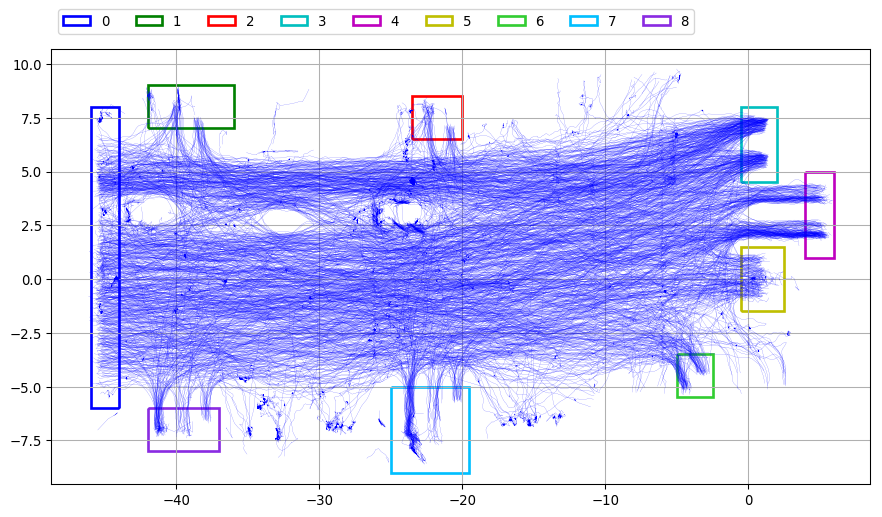

In [20]:
plot_trajectories(all_pedestrians, os.path.join(base, 'pedestrians'), sources, skip=100, mode='traj', showsources=True, color='b', save=True, show_image=False)

## Check why some pedestrians have the same origin and target id

       pedestrianId  source  destination
129628     12407167       1           -1
129632     12409235       3           -1
129634     12410153      -1           -1
129639     12412410      -1           -1
129640     12412770       0           -1
31410


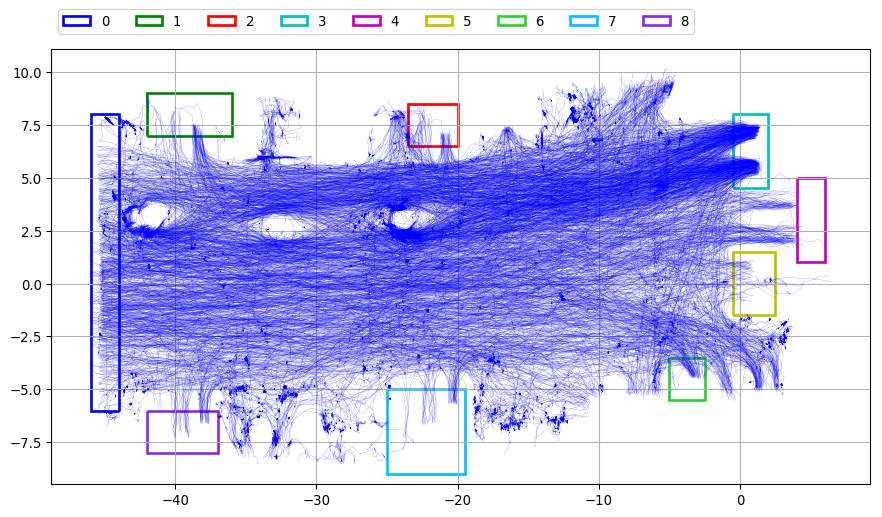

In [25]:
selected_mapping = mapping.loc[( (mapping['destination'] == -1))] # & (mapping['destination'] == -1) (mapping['source'] == -1)
print(selected_mapping.tail())
#selected_mapping = mapping.loc[mapping['pedestrianId'].isin(moved_peds)]
selected_mapping = selected_mapping.values.tolist()

print(len(selected_mapping))
selected_pedestrians = list(map(lambda x: '{0}'.format(x[0]), selected_mapping))

plot_trajectories(selected_pedestrians, os.path.join(base, 'pedestrians'), sources, skip=10, mode='traj', showsources=True, color='b', save=True, show_image = False)

# Create od-matrices

In [ ]:
def create_od_matrix(pedestrians):
    total = len(pedestrians.pedestrianId.values)
    grouped = pedestrians.groupby(['source','target']).size().reset_index().rename(columns={0:'count'})
    grouped['count'] = grouped['count'] / total * 100
    x = [-1] + list(range(len(sources)))
    
    od = np.zeros((len(x), len(x)))

    for i, s in enumerate(x):
        for j, t in enumerate(x):
            row = grouped.loc[(grouped['source'] == s) & (grouped['target'] == t)]
            value = 0
            
            if not row.empty:
                value = row['count'].values[0]
            
            od[i, j] = value
            
    return od, x


def stripMillies(row):
    row['datetime'] = row['datetime'].replace(microsecond=0)
    return row


## Load uniqe timesteps and convert them to datetimes

In [ ]:
# THIS SHOULD BE SKIPPED IF ALREADY DONE

# Load uniq timesteps and convert them to datetimes and cut of milliseconds
timestamps = pd.read_csv(os.path.join(base, 'uniq-timesteps.csv'), names=['timestamp'], header=None)
timestamps.insert(1, 'datetime', pd.to_datetime(timestamps['timestamp'], unit='ms'))
timestamps = timestamps.apply(stripMillies, axis=1)

# save datetimes
timestamps.to_csv(os.path.join(base, 'datetimes.csv'), index=False)

# only keep first timestep of each second
filtered = timestamps.drop_duplicates(subset='datetime', keep='first')

# save filtered datetimes
filtered.to_csv(os.path.join(base, 'datetimes-filtered.csv'), index=False)

In [ ]:
# create output folders
if not os.path.exists(os.path.join(base, 'hours')):
    os.makedirs(os.path.join(base, 'hours'))
    
if not os.path.exists(os.path.join(base, 'od')):
    os.makedirs(os.path.join(base, 'od'))

try:
    mapping
except NameError:
    mapping = pd.read_csv(os.path.join(base, 'mapping.csv'), dtype={'pedestrianId': 'str'})
    
try:
    filtered
except NameError:
    filtered = pd.read_csv(os.path.join(base, 'datetimes-filtered.csv'))
    filtered['datetime'] = pd.to_datetime(filtered['datetime'])
    
# group datetimes by hour
times = pd.DatetimeIndex(filtered.datetime)
grouped = filtered.groupby([times.hour])

In [ ]:
# read all trajectory data
df = pd.read_csv(
    os.path.join(base, 'objectstream_20190905_BS_sensor6_by_timestep.csv'), 
    names=['timestamp', 'pedestrianId', 'x', 'y'],
    header=None)

In [ ]:
# go over each group
for index, group in tqdm(grouped, total=len(grouped)):
    hour = group.datetime.iloc[0].hour
    
    # select all trajectories for given hour
    df_hour = df.loc[df['timestamp'].isin(group.timestamp.values)]

    # save trajectories for given hour
    df_hour.to_csv(os.path.join(base, 'hours', 'hour-{}.csv'.format(hour)), index=False)

    # select mapping for pedestrians contained in given hour
    pedestrians = mapping.loc[mapping['pedestrianId'].isin(df_hour.pedestrianId.unique())]

    # generate od matrix
    #od, x = create_od_matrix(pedestrians)

    # save od matrix
    #pd.DataFrame(od, columns=list(map(lambda x: str(x), x))).to_excel("../objectstream_20190905/od/od-matrix-{}.xlsx".format(hour))

    print('Hour {} done.'.format(hour))

In [ ]:

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

print(sorted_names)

mpl.plot(1,1,'--o',color=colors['deepskyblue'])
mpl.show()